In [177]:
import time
import os
import urllib.parse

import numpy as np
import tensorflow as tf
from tensorflow.core.example.example_pb2 import Example
from tensorflow.core.example.feature_pb2 import Feature
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd

tf.logging.set_verbosity(tf.logging.INFO)
print(tf.__version__)


1.12.0


# Get data
We are using the Census data. We are proposing a process to assess algorithmic bias in models, so instead of using the classification for whether people have >50k income, it will be used to classify if people should get a loan.

In [178]:
DOWNLOAD = False

csv_columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country", "loan"]

input_features = ["age", "workclass", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country"]

categorical_features = ["workclass", "education", "marital-status",
                       "occupation", "relationship", "ethnicity", "gender",
                       "native-country"]

label_column = 'loan'

csv_path = "data/adult.csv"

if DOWNLOAD:
    csv_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

# Read the dataset from the provided CSV and print out information about it.
df = pd.read_csv(csv_path, names=csv_columns, skiprows=[0], skipinitialspace=True)

# Converting Loan column to 1 if >50K
df[label_column] = df[label_column].apply(lambda x: ">50K" in x).astype(int)

# for c in ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]:
#         df[c] = pd.to_numeric(df[c])

# Delete unused column
del df["fnlwgt"] 

X_display = df.drop('loan', axis=1)
y_display = df['loan']
        
#Normalising to increase accuracy
dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
for k,dtype in dtypes:
    if dtype == "float64":
        df[k] = df[k].astype('float64')
        X[k] -= X[k].mean()
        X[k] /= X[k].std()    

# cat_columns = df.select_dtypes(['object']).columns
# df[cat_columns] = df[cat_columns].astype('category')
# df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

# g = df.groupby('loan')
# df = g.apply(lambda x: x.sample(g.size().min())).reset_index(drop=True)

df.head(5)

,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country,loan
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


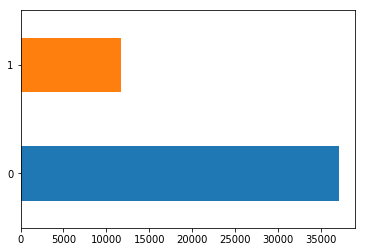

In [179]:
df.loan.value_counts().plot.barh()

In [180]:
X = df.drop(label_column, axis=1)
y = df[label_column]

In [181]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=101)

In [182]:
BATCH_SIZE = 100
num_epochs = None
shuffle = True

In [193]:

# gender = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             key="gender", hash_bucket_size=1000, dtype=tf.int8))

# ethnicity = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             key="ethnicity", hash_bucket_size=1000, dtype=tf.int8))

# marital_status = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "marital-status", hash_bucket_size=100, dtype=tf.int8))

# relationship = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "relationship", hash_bucket_size=100, dtype=tf.int8))

# workclass = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "workclass", hash_bucket_size=100, dtype=tf.int8))

# occupation = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "occupation", hash_bucket_size=1000, dtype=tf.int8))

# native_country = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "native-country", hash_bucket_size=1000, dtype=tf.int8))

# education = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "education", hash_bucket_size=1000, dtype=tf.int8))


# gender = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             key="gender", hash_bucket_size=5))

# ethnicity = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             key="ethnicity", hash_bucket_size=10))

# marital_status = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "marital-status", hash_bucket_size=10))

# relationship = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "relationship", hash_bucket_size=10))

# workclass = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "workclass", hash_bucket_size=10))

# occupation = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "occupation", hash_bucket_size=20))

# native_country = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "native-country", hash_bucket_size=50))

# education = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "education", hash_bucket_size=20))







gender = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list("gender", ["Female", "Male"]))
occupation = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list("occupation", list(df["occupation"].astype("category").cat.categories)))
marital_status = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list("marital-status", list(df["marital-status"].astype("category").cat.categories)))
relationship = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list("relationship", list(df["relationship"].astype("category").cat.categories)))
ethnicity = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list("ethnicity", list(df["ethnicity"].astype("category").cat.categories)))
education = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list("education", list(df["education"].astype("category").cat.categories)))
workclass = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list("workclass", list(df["workclass"].astype("category").cat.categories)))
native_country = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list("native-country", list(df["native-country"].astype("category").cat.categories)))





# occupation = tf.feature_column.embedding_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "occupation", hash_bucket_size=1000),
#         dimension=8)

# native_country = tf.feature_column.embedding_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "native-country", hash_bucket_size=1000),
#         dimension=8)

# education = tf.feature_column.embedding_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "education", hash_bucket_size=1000),
#         dimension=8)

In [194]:
age = tf.feature_column.numeric_column("age")
education_num = tf.feature_column.numeric_column("education-num")
capital_gain = tf.feature_column.numeric_column("capital-gain")
capital_loss  = tf.feature_column.numeric_column("capital-loss")
hours_per_week = tf.feature_column.numeric_column("hours-per-week")

# age = tf.feature_column.bucketized_column(
#     age, boundaries=list(range(0,100,5)))
# education_num = tf.feature_column.bucketized_column(
#     education_num, boundaries=list(range(0,16,1)))
# capital_gain = tf.feature_column.bucketized_column(
#     capital_gain, boundaries=list(range(0,100000,10000)))
# capital_loss  = tf.feature_column.bucketized_column(
#     capital_loss, boundaries=list(range(0,4000,1000)))
# hours_per_week = tf.feature_column.bucketized_column(
#     hours_per_week, boundaries=list(range(0,100,5)))

In [195]:
all_columns = [
    workclass,
    marital_status,
    gender,
    relationship,
    ethnicity,
    education,
    native_country,
    occupation,
    age,
    education_num,
    capital_gain,
    capital_loss,
    hours_per_week,
]

In [196]:

# batches_per_layer=int(0.5*X_train.shape[0]/BATCH_SIZE)
# m = tf.estimator.BoostedTreesClassifier(
#     model_dir=model_dir,
#     feature_columns=all_columns,
#     n_batches_per_layer=batches_per_layer,
# #     n_trees=1,
#     max_depth=12,
#     n_classes=2
# )
# print(batches_per_layer)

m = tf.estimator.LinearClassifier(
#             model_dir="models/model_DEEP_" + str(int(time.time())),
            feature_columns=all_columns,
#             hidden_units=[100, 50]
)



INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpm5tpv8dw', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f82088ffd30>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [197]:
%%time 

train_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        num_epochs=num_epochs,
        shuffle=shuffle)

m.train(input_fn=train_input_fn, steps=1000)

print('training done')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpm5tpv8dw/model.ckpt.
INFO:tensorflow:loss = 69.31474, step = 1
INFO:tensorflow:global_step/sec: 160.411
INFO:tensorflow:loss = 555.6281, step = 101 (0.625 sec)
INFO:tensorflow:global_step/sec: 220.092
INFO:tensorflow:loss = 366.43787, step = 201 (0.453 sec)
INFO:tensorflow:global_step/sec: 224.139
INFO:tensorflow:loss = 43.418964, step = 301 (0.446 sec)
INFO:tensorflow:global_step/sec: 223.451
INFO:tensorflow:loss = 99.80528, step = 401 (0.448 sec)
INFO:tensorflow:global_step/sec: 217.384
INFO:tensorflow:loss = 39.442253, step = 501 (0.460 sec)
INFO:tensorflow:global_step/sec: 223.552
INFO:tensorflow:loss = 75.393234, step = 601 (0.448 sec)
INFO:tensorflow:global_step/sec: 230.916
INFO:tensorflow:los

In [198]:
eval_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        y=y_test,
        batch_size=40,
        num_epochs=1,
        shuffle=shuffle)

results = m.evaluate(input_fn=eval_input_fn)

for r in results:
    print(r, results[r])


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-04-12:10:31
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpm5tpv8dw/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-04-12:10:33
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.80215657, accuracy_baseline = 0.7575241, auc = 0.75112295, auc_precision_recall = 0.5629024, average_loss = 1.3468357, global_step = 1000, label/mean = 0.24247594, loss = 53.77434, precision = 0.6476965, prediction/mean = 0.1802268, recall = 0.4036026
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpm5tpv8dw/model.ckpt-1000
accuracy 0.80215657
accuracy_baseline 0.7575241
auc 0.75112295
auc_precision_recall 0.5629024
average_loss 1.3468357
label/mean 0.24247594
loss 53.77434
precision 0.6476965
prediction/mean 0.1802

In [83]:
prediction_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        shuffle=False)

pred_gen = m.predict(input_fn=prediction_input_fn)

pred_list = []

for pred, actual in zip(pred_gen, y):
    tmp = []
    tmp.append(pred["logits"][0])   
    tmp.append(pred["logistic"][0])
    tmp.append(pred["probabilities"][0])
    tmp.append(pred["probabilities"][1])
    tmp.append(actual)
    tmp.append(pred["class_ids"][0])
    tmp.append(int(pred["class_ids"][0] == actual))
    tmp.append(int(pred["class_ids"][0] != actual and actual == 1))
    tmp.append(int(pred["class_ids"][0] != actual and actual == 0))

    #get index of maximum value of sigmoid. it will correspond to class
    pred_list.append(tmp)


pred_cols = ["logits", "logistic", "prob_neg", "prob_pos",
            "actual", "predicted", "is_correct", 
             "false_positive", "false_negative"]

pred_df = pd.DataFrame(pred_list, columns=pred_cols)
pred_df

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp6j459w8t/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


,logits,logistic,prob_neg,prob_pos,actual,predicted,is_correct,false_positive,false_negative
0,-4.829109,7.930251e-03,9.920697e-01,7.930251e-03,0,0,1,0,0
1,-4.256362,1.397569e-02,9.860243e-01,1.397569e-02,0,0,1,0,0
2,0.529305,6.293210e-01,3.706789e-01,6.293210e-01,0,1,0,0,1
3,-3.687093,2.443280e-02,9.755672e-01,2.443280e-02,0,0,1,0,0
4,-6.090479,2.259208e-03,9.977407e-01,2.259207e-03,0,0,1,0,0
5,-0.351223,4.130858e-01,5.869142e-01,4.130858e-01,0,0,1,0,0
6,-11.901478,6.780331e-06,9.999932e-01,6.780331e-06,0,0,1,0,0
7,-4.800372,8.159559e-03,9.918405e-01,8.159559e-03,1,0,0,1,0
8,-4.853338,7.741888e-03,9.922581e-01,7.741888e-03,1,0,0,1,0
9,-2.610441,6.846947e-02,9.315306e-01,6.846948e-02,1,0,0,1,0


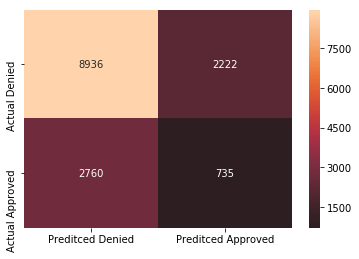

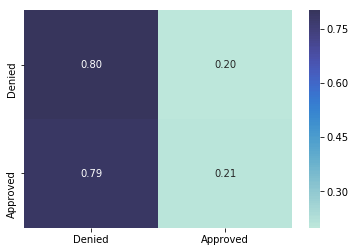

In [84]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(
    pred_df["actual"],
    pred_df["predicted"])

confusion_df = pd.DataFrame(confusion, 
            index=["Actual Denied", "Actual Approved"], 
            columns=["Preditced Denied", "Preditced Approved"])

confusion_scaled = \
    confusion.astype("float") / confusion.sum(axis=1)[:, np.newaxis]

confusion_scaled_df = pd.DataFrame(confusion_scaled, 
            index=["Denied", "Approved"], 
            columns=["Denied", "Approved"])

sn.heatmap(confusion_df, annot=True, fmt='d', center=1)
plt.show()

sn.heatmap(confusion_scaled_df, annot=True, fmt='.2f', center=1)
plt.show()

0.5102193464609391


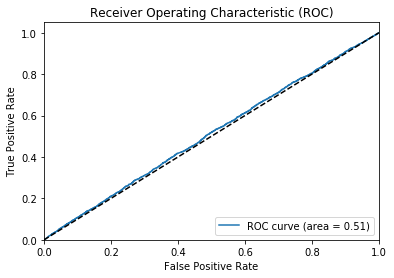

In [85]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(
        pred_df["actual"].values, pred_df["prob_pos"].values)

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [86]:

print(classification_report(pred_df["actual"], pred_df["predicted"]))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78     11158
           1       0.25      0.21      0.23      3495

   micro avg       0.66      0.66      0.66     14653
   macro avg       0.51      0.51      0.50     14653
weighted avg       0.64      0.66      0.65     14653



#### Data Analysis

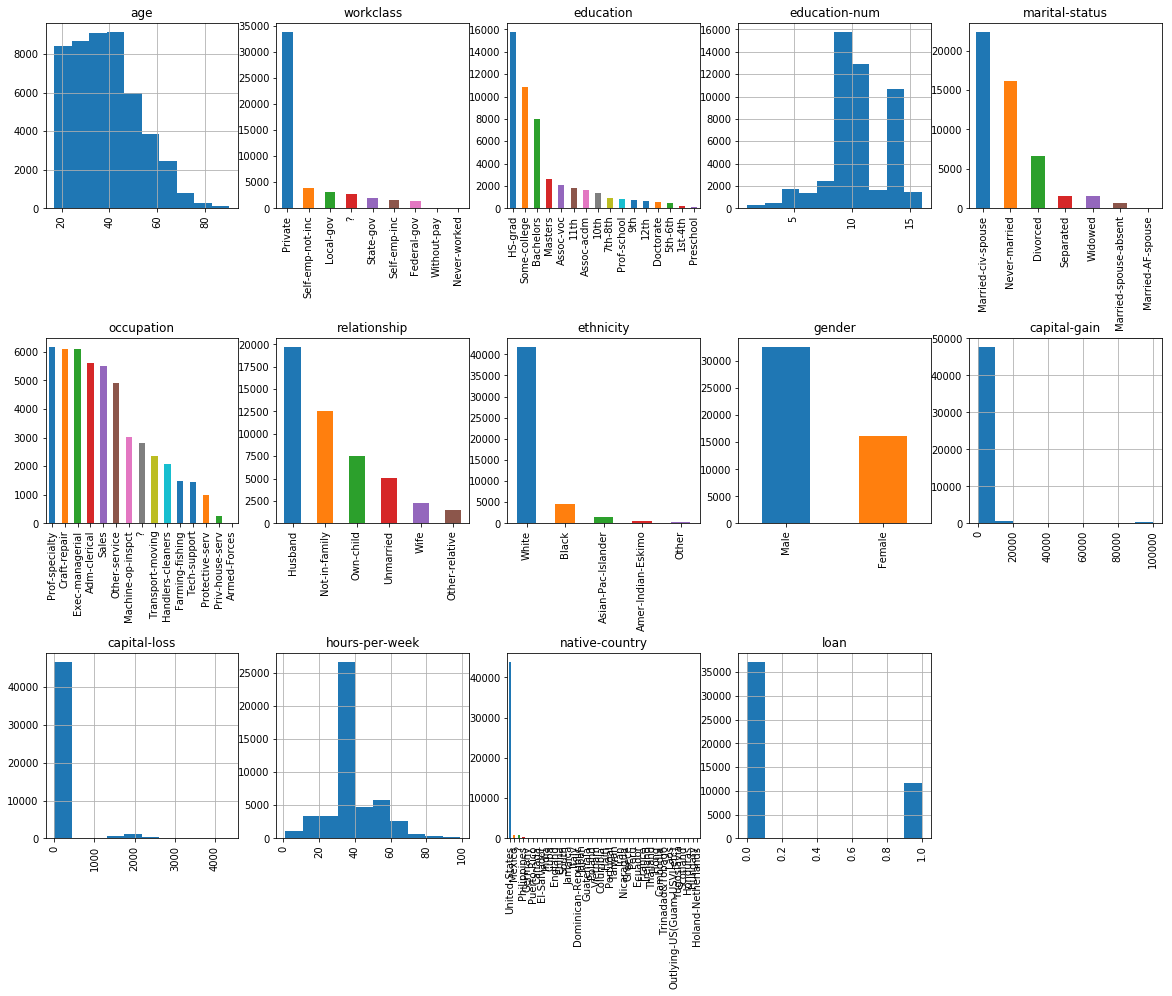

In [105]:
import math
fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(df.shape[1]) / cols)
for i, column in enumerate(df.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if df.dtypes[column] == np.object:
        df[column].value_counts().plot(kind="bar", axes=ax)
    else:
        df[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [98]:
X_analysis = X_display.copy()
X_analysis = X_analysis.join(pred_df)

X_analysis.tail(5)

,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,...,native-country,logits,logistic,prob_neg,prob_pos,actual,predicted,is_correct,false_positive,false_negative
48837,39,Private,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,...,United-States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48838,64,?,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,...,United-States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48839,38,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,...,United-States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48840,44,Private,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,...,United-States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48841,35,Self-emp-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,...,United-States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


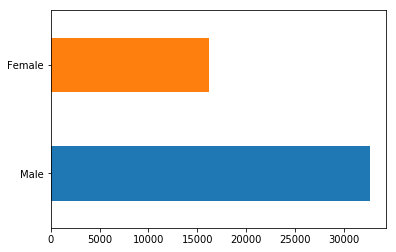

In [99]:
X_display.gender.value_counts().plot.barh()

In [ ]:
flds = ["gender", "age", "education-num", "capital-gain", 
                  "capital-loss", "hours-per-week"]


enc_summ = X_display[flds].groupby("gender", as_index=False).mean()
enc_summ

# Explainability with SHAP

In [ ]:
import shap
shap.initjs()


In [ ]:
tf_shap_idx = 39
tf_shap_x = X.iloc[tf_shap_idx,:]
tf_shap_display = X_display.iloc[tf_shap_idx,:]
tf_shap_y = y.iloc[tf_shap_idx]
print(tf_shap_y)

In [ ]:



def shap_predict_proba(shap_X):
    tmp_df = pd.DataFrame(data=shap_X, columns=input_features)
    # Converting to int
#     for c in ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]:
#         tmp_df[c] = pd.to_numeric(tmp_df[c])
    
    predict_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=tmp_df,
        batch_size=BATCH_SIZE,
        num_epochs=num_epochs,
        shuffle=shuffle)

    pred_gen = m.predict(input_fn=predict_input_fn)
    pred_list = []
    for pred in pred_gen:
        pred_list.append(pred["logits"][0])
    pred_arr = np.array(pred_list)

    return pred_arr

tf_explainer = shap.KernelExplainer(
                        shap_predict_proba, 
                        X.iloc[:100,:], 
                        link="identity")


In [ ]:
tf_shap_values = tf_explainer.shap_values(tf_shap_x, nsamples=500)

In [ ]:
shap.force_plot(tf_explainer.expected_value, tf_shap_values, tf_shap_display)

In [ ]:
tf_shap_idx_multi_from = 15
tf_shap_idx_multi_to = 40
tf_shap_x_multi = X.iloc[tf_shap_idx_multi_from:tf_shap_idx_multi_to,:]
tf_shap_display_multi = X_display.iloc[tf_shap_idx_multi_from:tf_shap_idx_multi_to,:]
tf_shap_y_multi = y.iloc[tf_shap_idx_multi_from:tf_shap_idx_multi_to]
print(tf_shap_y_multi)

In [ ]:
tf_shap_values_multi = tf_explainer.shap_values(tf_shap_x_multi, nsamples=500)

In [ ]:
shap.force_plot(tf_explainer.expected_value, tf_shap_values_multi, tf_shap_display_multi)

In [ ]:
shap.dependence_plot("gender", 
                     tf_shap_values_multi, 
                     tf_shap_x_multi, 
                     display_features=tf_shap_display_multi)

In [ ]:
shap.summary_plot(tf_shap_values_multi, tf_shap_x_multi)


# Census income classification with Keras

We use keras to perform this computation


In [ ]:
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Flatten, Concatenate, concatenate, Dropout, Lambda
from keras.models import Model
from keras.layers.embeddings import Embedding
from tqdm import tqdm
import shap

In [ ]:
# build model
input_els = []
encoded_els = []
for k,dtype in dtypes:
    input_els.append(Input(shape=(1,)))
    if dtype == "int8":
        e = Flatten()(Embedding(X_train[k].max()+1, 1)(input_els[-1]))
    else:
        e = input_els[-1]
    encoded_els.append(e)
encoded_els = concatenate(encoded_els)
layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
out = Dense(1)(layer1)

# train model
regression = Model(inputs=input_els, outputs=[out])
regression.compile(optimizer="adam", loss='binary_crossentropy')
regression.fit(
    [X_train[k].values for k,t in dtypes],
    y_train,
    epochs=50,
    batch_size=512,
    shuffle=True,
    validation_data=([X_test[k].values for k,t in dtypes], y_test)
)

In [ ]:
def f(X):
    values = regression.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    return values
keras_explainer = shap.KernelExplainer(f, X.iloc[:100,:])

In [ ]:
keras_idx = 10
keras_x = X.iloc[keras_idx,:]
keras_y = y.iloc[keras_idx]
keras_shap_values = keras_explainer.shap_values(keras_x, nsamples=500)

In [ ]:
shap.force_plot(keras_explainer.expected_value, keras_shap_values, keras_x)

In [ ]:
keras_y

# LIME on Tensorflow

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
tf_lime_explainer = LimeTabularExplainer(
                X_train.values,
                class_names=["No", "Yes"],
                feature_names=list(X_train.columns),
                categorical_features=categorical_features)

In [ ]:

def lime_predict_proba(lime_X):
    tmp_df = pd.DataFrame(data=lime_X, columns=input_features)
    # Converting to int
#     for c in ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]:
#         tmp_df[c] = pd.to_numeric(tmp_df[c])
    
    float_columns = tmp_df.select_dtypes(['float64']).columns
    tmp_df[float_columns] = tmp_df[float_columns].astype('int64')
    
    predict_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=tmp_df,
        batch_size=BATCH_SIZE,
        num_epochs=num_epochs,
        shuffle=shuffle)

    pred_gen = m.predict(input_fn=predict_input_fn)
    pred_list = []
    for pred in pred_gen:
        tmp = []
        pred_list.append(pred["probabilities"])
        
    pred_arr = np.array(pred_list)

    
    return pred_arr

tf_lime_explanation = tf_lime_explainer.explain_instance(
        X_train.iloc[0,:], lime_predict_proba, num_features=13) 

In [ ]:
tf_lime_explanation.as_pyplot_figure()

In [ ]:
tf_lime_explanation.show_in_notebook(show_table=True, show_all=True)

# Experiments

In [88]:
import sklearn
import shap

X,y = shap.datasets.adult()

In [90]:
X_train, X_valid, y_train, y_valid = 
    sklearn.model_selection.train_test_split(
        X, y, test_size=0.2, random_state=7)


In [91]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [93]:
predictions = knn.predict(X_valid)

In [96]:
print(classification_report(y_valid, predictions))

              precision    recall  f1-score   support

       False       0.89      0.91      0.90      4951
        True       0.70      0.63      0.66      1562

   micro avg       0.85      0.85      0.85      6513
   macro avg       0.79      0.77      0.78      6513
weighted avg       0.84      0.85      0.84      6513



In [109]:
import pandas as pd
import numpy as np
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.tree as tree
import seaborn as sns

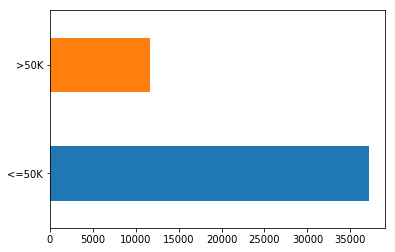

In [167]:

# Read the dataset from the provided CSV and print out information about it.
df = pd.read_csv(csv_path, names=csv_columns, skiprows=[0], skipinitialspace=True)

df["loan"] = df["loan"].apply(lambda x: ">50K" if x in [">50K", ">50K."] else "<=50K").astype(str)

df.loan.value_counts().plot.barh()

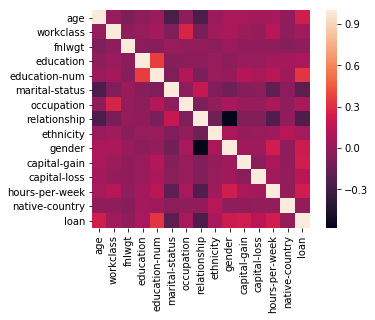

In [168]:
# Encode the categorical features as numbers
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

# Calculate the correlation and plot it
encoded_data, _ = number_encode_features(df)
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

In [169]:
X_train, X_test, y_train, y_test = train_test_split(
    encoded_data.drop("loan", axis=1), encoded_data["loan"], train_size=0.70)
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train.astype("float64")), 
                       columns=X_train.columns)

X_test = scaler.transform(X_test.astype("float64"))

/home/alejandro/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


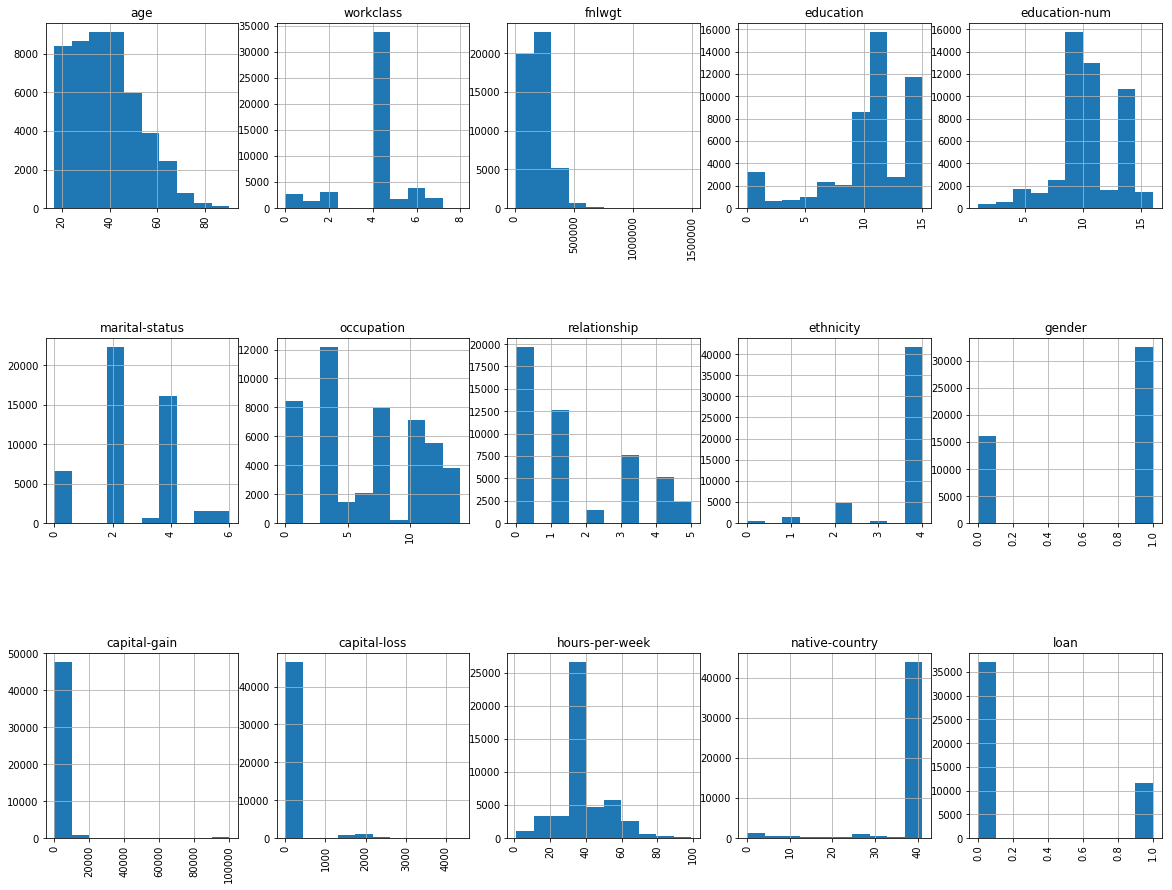

In [170]:
import math
encoded_data, encoders = number_encode_features(df)
fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(encoded_data.shape[1]) / cols)
for i, column in enumerate(encoded_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    encoded_data[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [171]:
print(encoders)

{'workclass': LabelEncoder(), 'education': LabelEncoder(), 'marital-status': LabelEncoder(), 'occupation': LabelEncoder(), 'relationship': LabelEncoder(), 'ethnicity': LabelEncoder(), 'gender': LabelEncoder(), 'native-country': LabelEncoder(), 'loan': LabelEncoder()}


/home/alejandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.83      0.94      0.89     11043
           1       0.71      0.43      0.53      3610

   micro avg       0.82      0.82      0.82     14653
   macro avg       0.77      0.69      0.71     14653
weighted avg       0.80      0.82      0.80     14653

F1 score: 0.533633


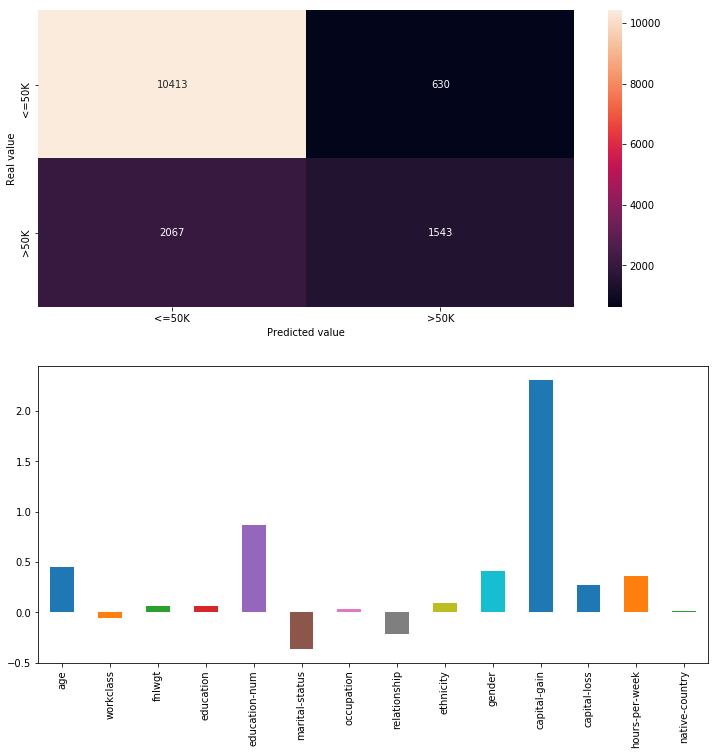

In [176]:
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=encoders["loan"].classes_, 
            yticklabels=encoders["loan"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")
print("F1 score: %f" % skl.metrics.f1_score(y_test, y_pred))
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
plt.subplot(2,1,2)
coefs.plot(kind="bar")
plt.show()